# Energy A.I. Hackathon 2021
---
# The Roaring Kitties!

<img src="images/roaring_kitty.gif " width="200" align="center">

### Team Members:
- **Sercan Gul**, *PhD*, *Hildebrand Department of Petroleum and Geosystems Engineering*
- **Chris Lawson**, *Department of Computer Science*
- **Ricardo Lara**, *PhD candidate*, *Hildebrand Department of Petroleum and Geosystems Engineering*
- **Adi Ojha**, *Deparment of Electrical and Computer Engineering*
- **Javier Santos**, *PhD candidate*, *Hildebrand Department of Petroleum and Geosystems Engineering*

**The University of Texas at Austin, Austin, Texas USA**

---

# Executive Summary

Only 4 short sentences.

1. What is the problem
    * We are tasked with trying to find the 3 year cumulative production of 10 wells that were with held from producing with neighboring wells.
2. What did your team do to address the problem?
    * We tackled this problem by first filling in missing values, generating new features from given ones to help us in model training, creating various models to help us predict production, and using uncertainty checking to verify our results.
3. What did your team learn?
    * We learned about a couple new models and a few imputed features (such as Voronoi plots) that could be used within our model training data.
4. What does your team recommend going forward?

---
# Workflow Steps
* [1 - Import Data](#import_data)
    * [1.1 - Data Cleaning](#data_cleaning)
    * [1.2 - Exploratory Data Analysis](#exploratory_data_analysis)
* [2 - Feature Engineering](#feature_engineering)
    * [2.1 - Feature Imputation](#feature_imputation)
        * [2.1.1 - Porosity and Facies](#porosity_and_faacies)
        * [2.2.2 - Permeability](#permeability)
    * [2.2 - Feature Augmentation](#feature_augmentation)
        * [2.2.1 - Average Porosity and Permeability per Well](#average_porosity_and_permeability)
        * [2.2.2 - Well Distances from Fracture](#distance_from_fracture)
        * [2.2.3 - Interwell Distances](#interwell_distances)
        * [2.2.4 - Drainage Area Aproximation (Voronoi Tesseletion)](#drainage_area)
* [3 - Regression](#regression)
* [4 - Uncertainty Analysis](#uncertainty_analysis)

### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import matplotlib.colors as plt_colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
#import plotly.express as px  # Uncomment for later
#import plotly.graph_objects as go # Uncomment for later
from numpy import nan
from numpy import isnan
import random
random.seed(1234567)

from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

from sklearn.model_selection import train_test_split                # train and test split
from sklearn.metrics import mean_squared_error, r2_score            # specific measures to check our models
from sklearn import linear_model

## Importing custom functions

The following import will include functions that we made in order to help shorten code. Short documentation will be given on function calls, but more documentation will be in the source file: 

In [2]:
# Put the import to the functions file
from utilities import *
from plotting_utilities import *

---
# 1 Import Data <a class="anchor" id="import_data"></a>

In [3]:
## Well Data
df_pre = pd.read_csv('data/wellbore_data_preproduction_well.csv')
df_prod = pd.read_csv('data/wellbore_data_producer_wells.csv')
df_hist = pd.read_csv('data/production_history.csv')

## 2D Data
AI = np.load("data/2d_ai.npy")                             # Acoustic impedence, kg/s-m^2
TOPS = np.load("data/2d_top_depth.npy")                    # Depth of reservoir top unit, meters
SAND = np.load("data/2d_sand_propotion.npy")               # Sand proportion
SANDY_SHALE = np.load("data/2d_sandy_shale_propotion.npy") # Sandy-shale proportion
SHALY_SAND = np.load("data/2d_shaly_sand_propotion.npy")   # Shaly-sand proportion
SHALE = np.load("data/2d_shale_propotion.npy")             # Shale proportion

The produced and produced wells dataframes in `df_pre` and `df_prod`, respectively, contain the following:
* Well ID
* X coordinate, $m$
* Y coordinate, $m$
* Depth, $m$
* Porosity, fraction
* Permeability, mD
* Acoustic impedance, $\frac{kg}{s-m^2}$
* Density, $g/cm^3$
* Rock facies: Sandstone, Shaly Sandstone, Sandy Shale, Shale
* Compressible velocity, $\frac{m}{s}$
* Young's modulus, $GPa$
* Shear velocity, $\frac{m}{s}$

## 1.1 Data Cleaning <a class="anchor" id="data_cleaning"></a>

For readability, we'll change the names of the features

In [4]:
column_names = [
                    'ID', 
                    'X', 
                    'Y', 
                    'depth', 
                    'por',    # Porosity
                    'perm',   # Permeability
                    'ai',     # Acoustic Impedance
                    'facies', 
                    'rho',    # Density
                    'Vc',     # Compressible velocity
                    'E',      # Young's modulus
                    'Vs',     # Shear velocity
                    'G'       # Shear modulus
                ]

hist_columns = [
                        'ID', 
                        'cum_oil_1y',    # Cumulative oil production in year 1, MBbls
                        'cum_oil_2y',    # Cumulative oil production in year 2, MBbls
                        'cum_oil_3y',    # Cumulative oil production in year 3, MBbls
                        'cum_water_1y',  # Cumulative oil production in year 1, MBbls
                        'cum_water_2y',  # Cumulative oil production in year 2, MBbls
                        'cum_water_3y'   # Cumulative oil production in year 3, MBbls
                    ]

# Rename column names
df_pre.columns = column_names
df_prod.columns = column_names
df_hist.columns = hist_columns

Substitute well indices for integers

In [5]:
df_pre.loc[:,'ID'] = df_pre.apply(lambda row: int(row['ID'].split('Well_no_')[1]), axis=1 )
df_prod.loc[:,'ID'] = df_prod.apply(lambda row: int(row['ID'].split('Well_no_')[1]), axis=1 )
df_hist.loc[:,'ID'] = df_hist.apply(lambda row: int(row['ID'].split('Well_no_')[1]), axis=1 )

Rename facies' labels

In [6]:
facies_labels = {'Sandstone':'SS',
                 'Shaly sandstone':'Sh-SS',
                 'Sandy shale':'SS-Sh',
                 'Shale':'Sh'}

# Rename facies labels
df_pre.loc[:,'facies'] = df_pre.apply(lambda row: facies_labels[row['facies']]  if isinstance(row['facies'], str)
                                                    else row['facies'], axis=1)

df_prod.loc[:,'facies'] = df_prod.apply(lambda row: facies_labels[row['facies']]  if isinstance(row['facies'], str)
                                                    else row['facies'], axis=1)

In [7]:
df_all = pd.concat([df_prod, df_pre]).reset_index()

Calculate water cut per year

In [8]:
# Oil
rate_oil_1y = df_hist['cum_oil_1y']
rate_oil_2y = df_hist['cum_oil_2y'] - df_hist['cum_oil_1y']
rate_oil_3y = df_hist['cum_oil_3y'] - df_hist['cum_oil_2y']

# Water
rate_water_1y = df_hist['cum_water_1y']
rate_water_2y = df_hist['cum_water_2y'] - df_hist['cum_water_1y']
rate_water_3y = df_hist['cum_water_3y'] - df_hist['cum_water_2y']

## Water cut per year
df_hist['wc_1y'] = rate_water_1y / (rate_oil_1y + rate_water_1y)
df_hist['wc_2y'] = rate_water_2y / (rate_oil_2y + rate_water_2y)
df_hist['wc_3y'] = rate_water_2y / (rate_oil_2y + rate_water_3y)

In [9]:
# Add well locations
df_hist[['X', 'Y']] = df_prod.drop_duplicates(subset=['ID'])[['X', 'Y']].values

## 1.2 Exploratory Data Analysis <a class="anchor" id="exploratory_data_analysis"></a>

### 1.2.1 Features statistics

##### Preproduction:

In [10]:
df_pre.drop(['ID', 'X', 'Y'], axis=1).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
depth,200.0,3.053751e+03,3.194208,3.046740e+03,3.051255e+03,3.053750e+03,3.056245e+03,3.061170e+03
por,176.0,1.287246e-01,0.038333,4.845000e-02,1.124650e-01,1.394250e-01,1.569350e-01,1.839700e-01
perm,48.0,1.252225e+02,83.653397,1.285630e+01,5.936801e+01,1.095367e+02,1.688792e+02,3.226680e+02
ai,187.0,7.310066e+06,326890.102970,6.617929e+06,7.077094e+06,7.234540e+06,7.498666e+06,8.108090e+06
rho,163.0,2.033922e+00,0.386902,1.482503e+00,1.743189e+00,2.000809e+00,2.243124e+00,3.508268e+00
Vc,168.0,3.687545e+03,701.744626,2.227977e+03,3.147726e+03,3.596592e+03,4.220014e+03,5.320216e+03
E,167.0,2.747356e+01,5.690831,1.653538e+01,2.321555e+01,2.661058e+01,3.118868e+01,4.390406e+01
Vs,174.0,1.668404e+03,90.723222,1.425171e+03,1.602559e+03,1.666324e+03,1.731496e+03,1.909247e+03
G,176.0,5.809301e+00,1.373386,2.463956e+00,4.908638e+00,5.722072e+00,6.674499e+00,1.033815e+01


##### Post-Production:

In [11]:
df_prod.drop(['ID', 'X', 'Y'], axis=1).describe().transpose()

,count,mean,std,min,25%,50%,75%,max
depth,1460.0,3.055811e+03,4.353335,3.045620e+03,3.052720e+03,3.055790e+03,3.058983e+03,3.066300e+03
por,1268.0,1.277455e-01,0.036020,4.027000e-02,1.139525e-01,1.374950e-01,1.523250e-01,1.889100e-01
perm,284.0,1.121827e+02,80.894436,2.214604e+00,5.154098e+01,9.398072e+01,1.545849e+02,4.892194e+02
ai,1357.0,7.325786e+06,310112.544293,6.559277e+06,7.111056e+06,7.274333e+06,7.503378e+06,8.249272e+06
rho,1248.0,2.052521e+00,0.417622,1.421943e+00,1.734052e+00,1.988542e+00,2.229507e+00,3.530373e+00
Vc,1276.0,3.688658e+03,727.216238,1.661828e+03,3.178389e+03,3.664197e+03,4.214925e+03,6.179653e+03
E,1261.0,2.728888e+01,5.424608,1.320513e+01,2.346654e+01,2.664747e+01,3.087463e+01,4.812329e+01
Vs,1270.0,1.676158e+03,100.630094,1.307887e+03,1.608928e+03,1.674837e+03,1.746081e+03,1.989829e+03
G,1285.0,5.752640e+00,1.518699,1.650985e+00,4.757475e+00,5.610267e+00,6.600503e+00,1.182004e+01


### 1.2.2 Conditional Distributions
We saw that the correlation between each variable could be clustered by the facies we used.<br>

i.e. You can see clear 'packs' of colors in the below pair plot <br>
This motivated us to engineer features related facies of the rock.

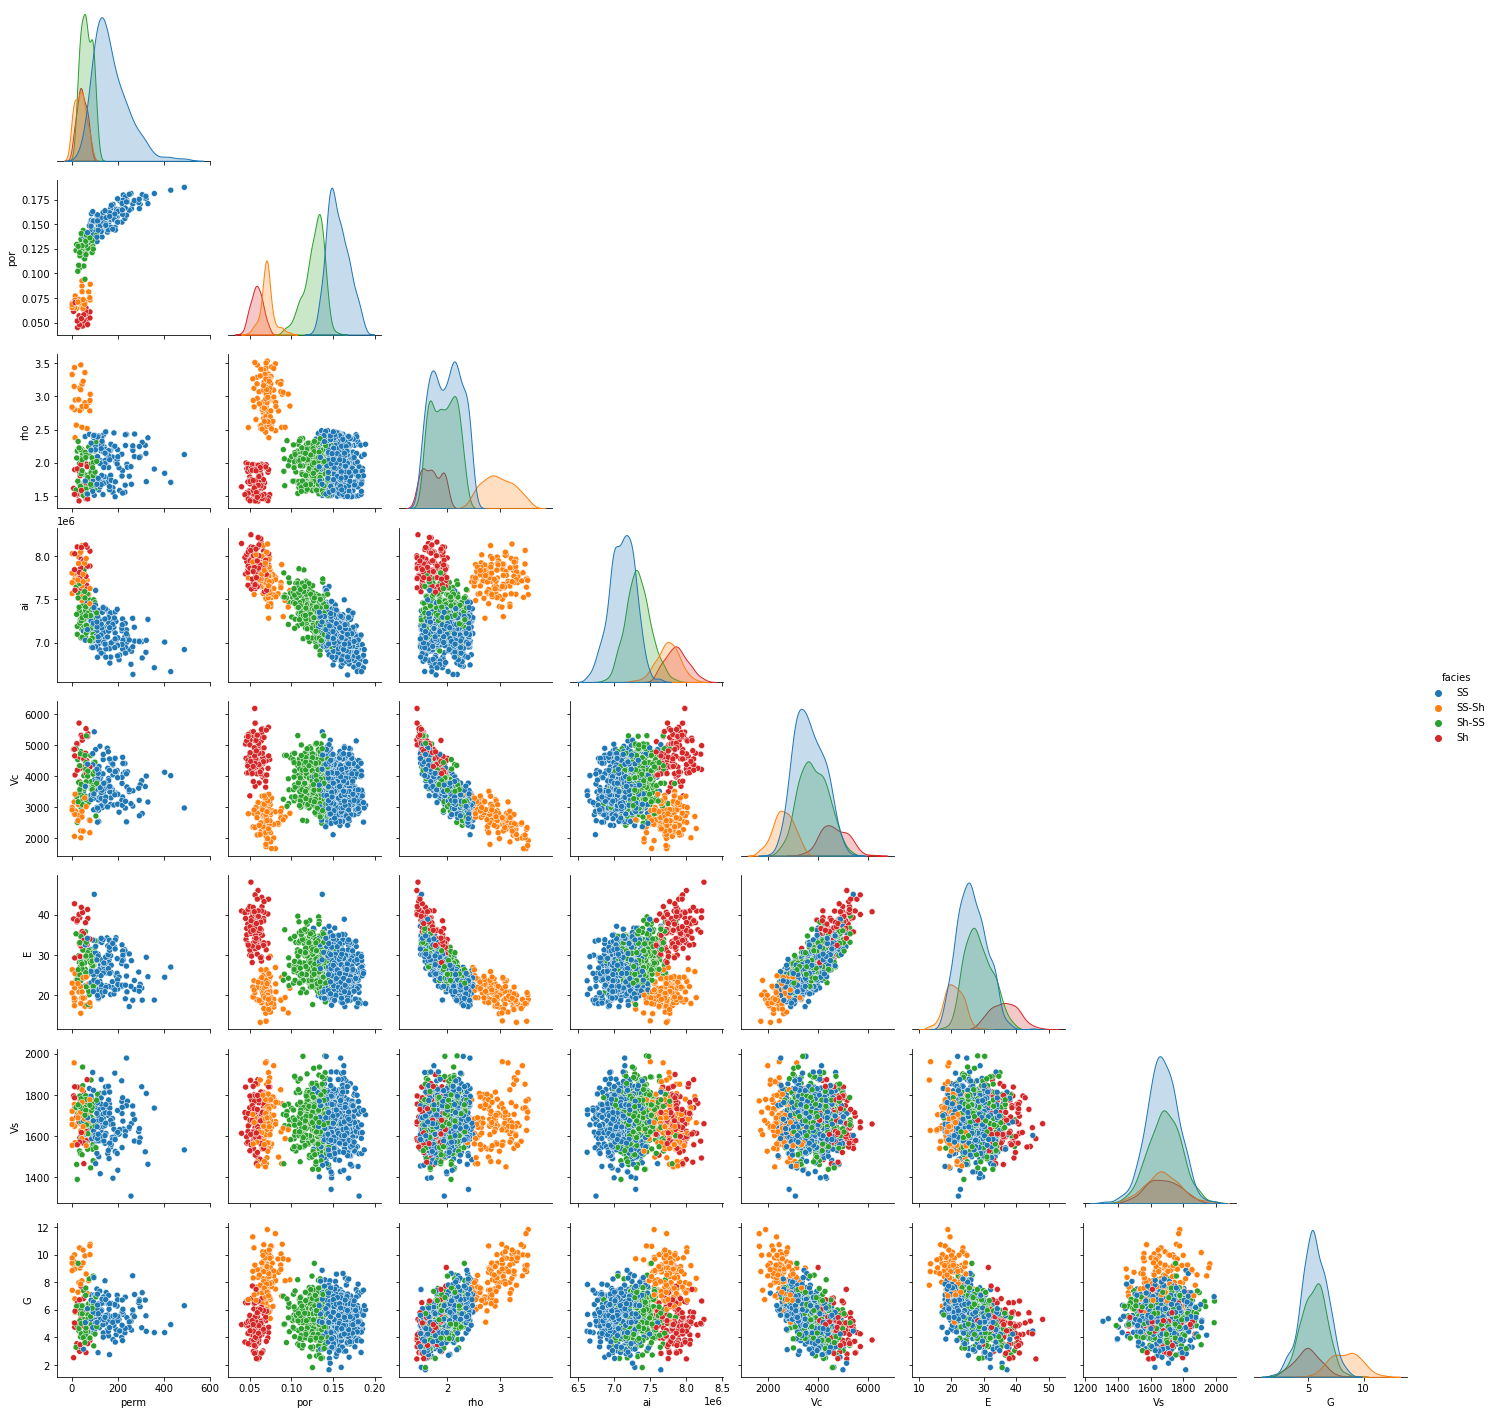

In [12]:
sns.pairplot(df_all[['perm', 'por', 'rho', 'ai', 'facies', 'Vc', 'E', 'Vs', 'G']], hue='facies', corner=True);

With this we can see that there are some variables that are correlated to each other. So because of this, we can omit some features from our model. Such as with the correlation between Acustic Impedance and Porosity, we can afford to drop Acustic Impedance as it is incapsulated in Porosity.

###  1.2.3 - Well Location Visualization
We wanted to visualize the water bed, and depth of each well.<br>
We also wanted to see where our test wells would be located relative to the fault line, and our training wells.

##### Well Location and Depth (3D plot)

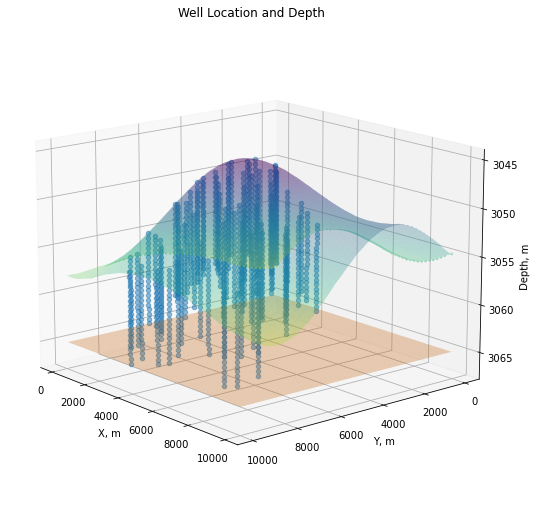

In [13]:
# Create mesh grid
x = np.arange(0, 200, 1)*50
y = np.arange(0, 200, 1)*50
X, Y = np.meshgrid(x,y)

well_locs = df_prod[["ID", "X", "Y", "depth"]]
WOC = np.ones((200,200)) * 3065

fig = plt.figure(figsize=(12, 9)); ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, TOPS, cmap='viridis', alpha=0.3)
ax.plot_surface(X, Y, WOC, alpha=0.3)
ax.scatter3D(well_locs["X"], well_locs["Y"], well_locs["depth"],depthshade=False, alpha = 0.5)
ax.view_init(195,220)
plt.title("Well Location and Depth")
plt.xlabel("X, m")
plt.ylabel("Y, m")
ax.set_zlabel("Depth, m");

This was important to view as, if a well had entries that were above the top depth, we would have to remove those entries as they would not help with predicting oil production

Next we can visualize some spacial data regarding our reservoir.

This is to see how the wells line up with the data.

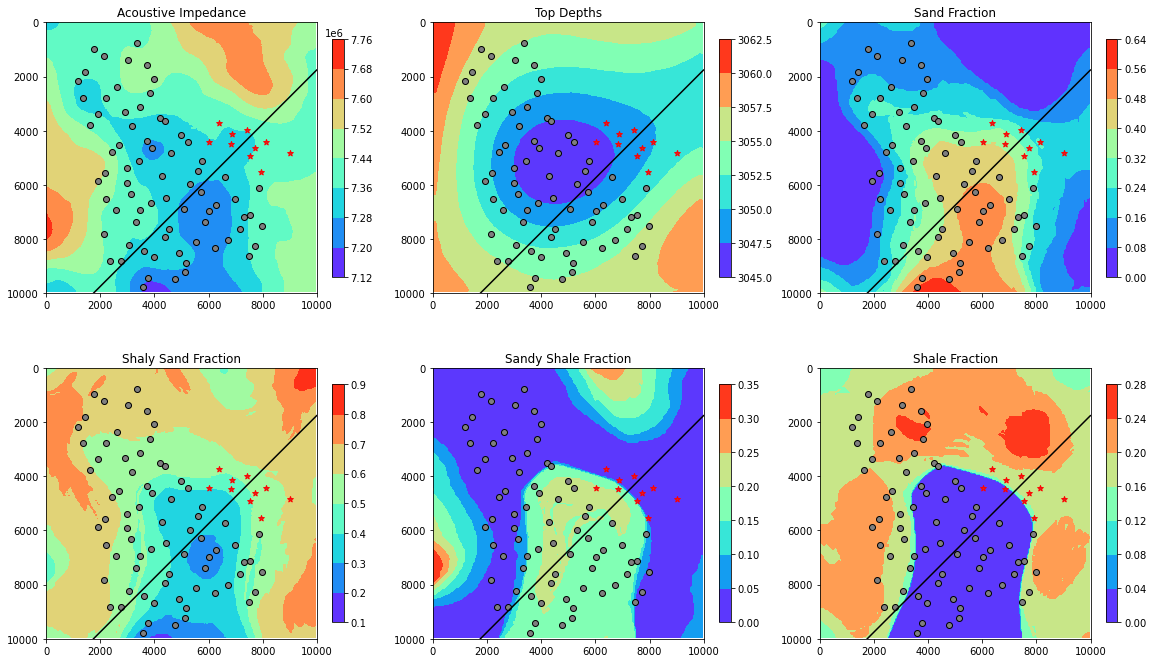

In [14]:
# Create mesh grid
x = np.arange(0, 200, 1)*50
y = np.arange(0, 200, 1)*50
XX, YY = np.meshgrid(x,y)

# Get 2D data into dictionary for plotting purposes
grid_data = {'ai':AI, 'top':TOPS, 'sand':SAND, 'shaly_sand':SHALY_SAND, 'sandy_shale':SANDY_SHALE, 'shale':SHALE}
grid_data_labels = ['Acoustive Impedance','Top Depths','Sand Fraction','Shaly Sand Fraction',
                    'Sandy Shale Fraction', 'Shale Fraction']

# Get well locations
df_pre_loc = df_pre.drop_duplicates(subset=['ID'])[['X', 'Y']]
df_prod_loc = df_prod.drop_duplicates(subset=['ID'])[['X', 'Y']]

# Calculate fault location
x_fault = [i for i in range(1750,10000,10)]
y_fault = [11750-i for i in x_fault]

# Plot
fig, ax = plt.subplots(2, 3, figsize=(16,10))
ax = ax.flatten()

for i, data in enumerate(grid_data.values()):
    im = ax[i].contourf(XX,YY, data, shading='auto', edgecolors='face', cmap='rainbow')          # 2D Scalar field
    ax[i].scatter(df_prod_loc["X"], df_prod_loc["Y"], c="tab:gray", edgecolors='k')              # Producer's locations
    ax[i].scatter(df_pre_loc["X"], df_pre_loc["Y"], marker='*', c="tab:red", edgecolors='r')                 # Pre-producers Locations
    
    fig.colorbar(im, fraction=0.04,ax=ax[i])
    ax[i].set_title(grid_data_labels[i])
    ax[i].set_aspect('equal', adjustable='box')   
    ax[i].plot(x_fault, y_fault, "k", ls = '-')
    ax[i].set_xlim((0,10000)); ax[i].set_ylim((0,10000))
    ax[i].invert_yaxis()

fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.3)

We noticed that our testing wells are not speckled inbetween our training wells. Rather, they are in a separate cluster away from the others.<br>
Therefore, we cannot rely on predicting effects in a local area; we're going to have to establish a relation between the subsurface and production in order to accurately predict those wells.<br>

---
# 2 Feature Engineering <a class="anchor" id="feature_engineering"></a>

Now that were are all done with interpreting the data and what we have, now we are tasked with imputing all the data that we need to go ahead and train our models.

Firstly, we need to see just how incomplete our data is:

In [15]:
pre_prod_empty = pd.DataFrame(columns=["Feature", "% Complete"])

nans_1 = df_pre.isnull().sum(axis = 0).tolist()
for feature in range(0, len(df_pre.columns)):
    pre_prod_empty.loc[feature, "Feature"] = df_pre.columns[feature]
    pre_prod_empty.loc[feature, "% Complete"] = (1-nans_1[feature] / len(df_pre.index))*100

pre_prod_empty

,Feature,% Complete
0,ID,100.0
1,X,100.0
2,Y,100.0
3,depth,100.0
4,por,88.0
5,perm,24.0
6,ai,93.5
7,facies,90.5
8,rho,81.5
9,Vc,84.0


In [16]:
given_prod_empty = pd.DataFrame(columns=["Feature", "% Complete"])

nans_1 = df_prod.isnull().sum(axis = 0).tolist()
for feature in range(0, len(df_prod.columns)):
    given_prod_empty.loc[feature, "Feature"] = df_prod.columns[feature]
    given_prod_empty.loc[feature, "% Complete"] = (1-nans_1[feature] / len(df_prod.index))*100

given_prod_empty

,Feature,% Complete
0,ID,100.0
1,X,100.0
2,Y,100.0
3,depth,100.0
4,por,86.849315
5,perm,19.452055
6,ai,92.945205
7,facies,91.09589
8,rho,85.479452
9,Vc,87.39726


Now we know which features missing and by what percentage. Given how important permeability is to predicting production given our domain knowledge, we need to go ahead and fill in those values.

Our strategy to doing this is by first imputing all the other values, and then predicting permeability.

### 2.1 Features Imputation <a class="anchor" id="feature_imputation"></a>
Here we will go ahead and use Random Forest Regressions along with Classifiers to go ahead an fill in the missing values

### 2.1.1 Facies and Porosity <a class="anchor" id="facies_and_porosity"></a>

Ocular inspection shows a relationship between porosity and density for different facies.

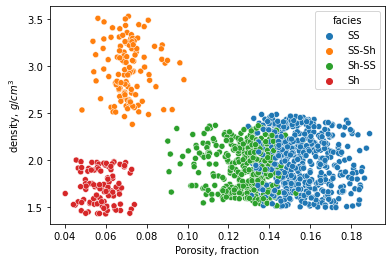

In [17]:
fig, ax = plt.subplots()
img = sns.scatterplot(data=df_all, x='por', y='rho', hue='facies', ax=ax)
ax.set_ylabel('density, $g/cm^3$')
ax.set_xlabel('Porosity, fraction');

We define a function that returns a dataframe with these values found by random forest

In [18]:
def por_facies_imputer(dataframe):
    """
    Imputes missing porosity and facie labels using RF 

    Args:
        df ([DataFrame]): The dataframe should includes the 
        following columns: ['X', 'Y', 'depth', 'por', 'rho','facies']
    Returns:
        df ([DataFrame])
    """
    df_original = dataframe.copy(deep=False)
    df = df_original.loc[:,['X', 'Y', 'depth', 'por', 'rho','facies']]
    categorical = ['facies']
    numerical = ['X', 'Y', 'depth', 'por', 'rho']
    df['Imputed'] = (df.isnull().sum(axis=1)) > 0
    df[categorical] = df[categorical].apply(lambda series: pd.Series(
                                            LabelEncoder().fit_transform(series[series.notnull()]),
                                            index=series[series.notnull()].index))

    # Instatiate imputers
    imp_num = IterativeImputer(estimator=RandomForestRegressor(),
                            initial_strategy='mean',
                            max_iter=20, random_state=0)
    imp_cat = IterativeImputer(estimator=RandomForestClassifier(), 
                            initial_strategy='most_frequent',
                            max_iter=20, random_state=0)

    # Fit
    df[numerical] = imp_num.fit_transform(df[numerical])
    df[categorical] = imp_cat.fit_transform(df[categorical])     

    #Perform 'manual' corrections to facies information with density and porosity values
    df['facies'] = np.where((df.por < 0.1) & (df.rho > 2.40), 1,df.facies)
    df['facies'] = np.where((df.por < 0.08) & (df.rho < 2.25) , 2,df.facies)
    df['facies'] = np.where((df.por < 0.13) & (df.por > 0.08) & (df.rho < 2.40),3,df.facies)

    #Update por, rho and facies with the predicted values for missing data
    df_original["por"] = df["por"]
    df_original["rho"] = df["rho"]
    df_original["facies"] = df["facies"]

    facies_map = {
        0 : 'SS',
        1 : 'SS-Sh',
        2 : 'Sh',
        3 : 'Sh-SS'
    }

    df_original["facies"] = df_original["facies"].map(facies_map)

    print('---------------------------------')
    print('Facies initial missing values = ' + str(dataframe['facies'].isna().sum()))
    print('Facies final missing values = ' + str(df_original['facies'].isna().sum()))
    print('---------------------------------')

    return df_original

In [19]:
df_all2 = por_facies_imputer(df_all)

---------------------------------
Facies initial missing values = 149
Facies final missing values = 0
---------------------------------


### 2.1.2 Permeability <a class="anchor" id="permeability"></a>

Now that we have our imputed values for everything other than permeability, we need to fill in those values.

Now before we can go ahead and decide how we impute permeability, we'll plot everything up and fit a line to it to see how it looks.


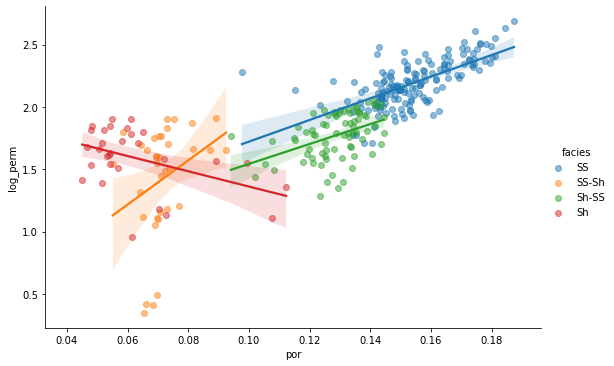

In [20]:
df_all['log_perm'] = np.log10(df_all['perm'])
sns.lmplot(x='por', y='log_perm', data=df_all, hue='facies', aspect=1.5, scatter_kws={'alpha':0.5});

We define a function to replace the missing permeability values with the estimates of linear-model from porosity.
Given this plot, our strategy for imputing the values will be as follows:
* For Sandstone and Shaly sandstone:
    * Given how linearly correlated those points look, we can just impute using a linear regression model.
* For Shale and Sandy Shale:
    * Given how how clustered the data looks, we'll just impute the values with the mean for the respective facie.

In [21]:
def perm_imputer(dataframe, random_state=0):
    """[Calculate missing permeability values using linear regression
    for Sandstone and Shaly Sandstone, and mean values for Shale and
    Sandy Shale facies]

    Args:
        dataframe ([DataFrame]): [DataFrame with porosity ['por'] and facies ['facies']]

    Returns:
        dataframe ([DataFrame]): [DataFrame with calculate permeability ['perm'] and log permeability ['log_perm']]
    """


    df =  dataframe.copy(deep=False)
    df['log_perm'] = np.log10(df['perm'])

    # Get data
    x_SS = df[df.facies =='SS'].dropna()['por'].values[:,np.newaxis]
    y_SS = df[df.facies =='SS'].dropna()['log_perm'].values[:,np.newaxis]
    
    x_shS = df[df.facies =='Sh-SS'].dropna()['por'].values[:,np.newaxis]
    y_shS = df[df.facies =='Sh-SS'].dropna()['log_perm'].values[:,np.newaxis]    
    
    # Taking original STD values to then incorperate into the imupted values
    SS_std = y_SS.std()
    shS_std = y_shS.std()
    Sh_std = df[df.facies =='Sh'].dropna()['log_perm'].values[:,np.newaxis].std()
    SS_Sh_std = df[df.facies =='SS-Sh'].dropna()['log_perm'].values[:,np.newaxis].std()
    
    
    # Instantiate models
    lin_reg_SS = linear_model.LinearRegression()
    lin_reg_shS = linear_model.LinearRegression()

    # Train models
    lin_reg_SS.fit(x_SS, y_SS)
    lin_reg_shS.fit(x_shS, y_shS);

    # Calculate missing permeabilities
    # Sandstone
    filter = (df['facies']=='SS') & (df.por.notnull()) & (df.perm.isnull())
    df.loc[filter, 'log_perm'] = lin_reg_SS.predict(df.loc[filter, 'por'].values[:,np.newaxis])
    df.loc[filter, 'perm'] = df.loc[filter, 'log_perm']

    rand_std_pos = 3*random.random()
    rand_std_neg = 3*random.random()
    df.loc[filter, 'perm'] = df.loc[filter, 'perm'] + (SS_std*(rand_std_pos + rand_std_neg))
    df.loc[filter, 'perm'] = 10 ** df.loc[filter, 'perm']
    
    # Shaly Sandstone
    filter = (df['facies']=='Sh-SS') & (df.por.notnull()) & (df.perm.isnull())
    df.loc[filter, 'log_perm'] = lin_reg_shS.predict(df.loc[filter, 'por'].values[:,np.newaxis])
    df.loc[filter, 'perm'] = df.loc[filter, 'log_perm']
    
    rand_std_pos = 3*random.random()
    rand_std_neg = 3*random.random()
    df.loc[filter, 'perm'] = df.loc[filter, 'perm'] + (shS_std*(rand_std_pos + rand_std_neg))
    df.loc[filter, 'perm'] = 10 ** df.loc[filter, 'perm']
    
    
    # For Shale and Sandy Shale we used a mean imputer
    # Instatiate imputer
    mean_imputer = SimpleImputer(strategy='mean')

    # Shale
    filter = df.facies == 'Sh','perm'
    df.loc[filter] = mean_imputer.fit_transform(df.loc[filter].values[:, np.newaxis] )
    rand_std_pos = 3*random.random()
    rand_std_neg = 3*random.random()
    df.loc[filter] = df.loc[filter] + (Sh_std*(rand_std_pos + rand_std_neg))

    # Sandy shale
    filter = df.facies == 'SS-Sh','perm'
    df.loc[filter] = mean_imputer.fit_transform(df.loc[filter].values[:, np.newaxis] )
    
    rand_std_pos = 3*random.random()
    rand_std_neg = 3*random.random()
    df.loc[filter] = df.loc[filter] + (SS_Sh_std*(rand_std_pos + rand_std_neg))

    
    # Re-calculate log perm
    df['log_perm'] = np.log10(df['perm'])

    print('---------------------------------')
    print('Permeability initial missing values = ' + str(dataframe['perm'].isna().sum()))
    print('Permeability final missing values = ' + str(df['perm'].isna().sum()))
    print('---------------------------------')

    return df

Impute values to dataframe `df_all2`

In [22]:
df_all2 = perm_imputer(df_all2)
df_all2['log_perm'] = np.log10(df_all2['perm']) # Update log10 permeability values

---------------------------------
Permeability initial missing values = 1328
Permeability final missing values = 0
---------------------------------


### 2.1.3 Permeability and Porosity 2D

**Porosity**

In [23]:
x = df_all2.dropna()['ai'].values[:,np.newaxis]
y = df_all2.dropna()['por'].values[:,np.newaxis]

lin_reg = linear_model.LinearRegression()  # Instantiate model
lin_reg.fit(x, y)                         # Train model

POR = lin_reg.predict(AI.flatten().reshape(-1,1)).reshape((200,200))    # Predict porosity

**Permeability**

In [24]:
x = df_all2.dropna()['por'].values[:,np.newaxis]
y = df_all2.dropna()['log_perm'].values[:,np.newaxis]

lin_reg = linear_model.LinearRegression()
lin_reg.fit(x, y)
LOGPERM = lin_reg.predict(POR.flatten().reshape(-1,1)).reshape((200,200))

### 2.2 Feature Engineering <a class="anchor" id="feature_augmentation"></a>

Now that we've filled in missing values from what we were provided, we want to go ahead and include some variables that can be imputed from the data that we were given that may hold some additional information. <br>

The features that we will be including into our model training are:
* Well averages
    * Average Porosity per facie
    * Average Permiability per facie
    * Facies fractions
* Distance from water-oil contact
* Distance from fracture
* Distance to closest well
* Voronoi area


### 2.2.1 Average porosity and permeability per well <a class="anchor" id="average_porosity_and_permeability"></a>

Due to some of the plots, there might be some stronger correlations between oil production and a particular facie. So for each well, we will be extracting the:
* Average porosity per facie
* Average permeability per facie
* Facie percentage make up of well

In [25]:
def average_per_well(dataframe):
    df = dataframe.copy(deep=False)
    facies = df['facies'].unique()                          # Get the facies names
    df_ave = df.groupby(by='ID', as_index=False).mean()
    df_grouped = df.groupby(by=['ID', 'facies'])        # Group dataframe by well ID and facie
    dist_woc = np.zeros(len(df_ave))

    for ID in range(1,len(df_ave)+1): # Loop all wells
        for facie in facies:          # Loop all wells
            try: # Some wells do not have some facies
                df_ave.loc[df_ave.ID==ID, facie +'_perm'] = df_grouped.get_group((ID, facie))['perm'].mean()
                df_ave.loc[df_ave.ID==ID, facie +'_por'] = df_grouped.get_group((ID, facie))['por'].mean()    
                df_ave.loc[df_ave.ID==ID, facie +'_fraction'] = df_grouped.get_group((ID, facie)).shape[0] / 20
            except KeyError:
                pass
        
        # Per well
        perm = df[df.ID == ID]['perm']
        df_ave.loc[df_ave.ID==ID,'perm_w_ave'] = perm.sum() * 0.05 / 9.5       # Weighted-Average
        df_ave.loc[df_ave.ID==ID,'perm_h_ave'] = 9.5 / np.sum(0.05 / perm)     # Harmonic-Average
        dist_woc[ID-1] = 3067.4 - df.loc[df.ID==ID, 'depth'].values[0]         # Distance from water-oil contact

    df_ave['dist_woc'] = dist_woc
    df_ave['SS+Sh-SS_fraction'] = df_ave['SS_fraction'] + df_ave['Sh-SS_fraction']
    
    # We add the medianfor the missing values
    df_ave.fillna(value=df_ave.median(), inplace=True)
    return df_ave

In [26]:
df_ave = average_per_well(df_all2)

### 2.2.2 Distance from fracture  <a class="anchor" id="distance_from_fracture"></a>
Define function to calculate distance from fracture from well coordinates.
Reasoning for this is that, while it was said that the fracture may not impact that much on production, we want to make sure.

In [27]:
def distance_from_fracture(X, Y):
    A = np.array([1e4-1750, 1e4-1750])         # Fault vector origin at Y= 10,000 and X = 1,750
    B = np.array([X - 1750, 1e4 - Y])          # Position vector for well
    
    norm = np.linalg.norm
    θ = np.arccos(A @ B / (norm(A) * norm(B))) # Angle between fault and position vector
    
    return norm(B) * np.sin(θ)

Apply function to dataframe

In [28]:
df_ave.loc[:,'dist_frac'] = df_ave.apply(lambda row: distance_from_fracture(row.X, row.Y), axis=1 )

### 2.2.3 Interwell distances <a class="anchor" id="interwell_distances"></a>

### 2.2.4 Drainage Area Approximation - Voronoi Tesellation <a class="anchor" id="drainage_area"></a>

In addition to make sure that the closest wells do not have a high impact on oil production on it's neighbor, we were also curious to see how the drainage and Original Oil in Place (OOIP) affected the data. So we will be producing Voronoi plots, finding the area of them, and including them in our data.

In [29]:
from scipy.spatial import Voronoi, voronoi_plot_2d,ConvexHull

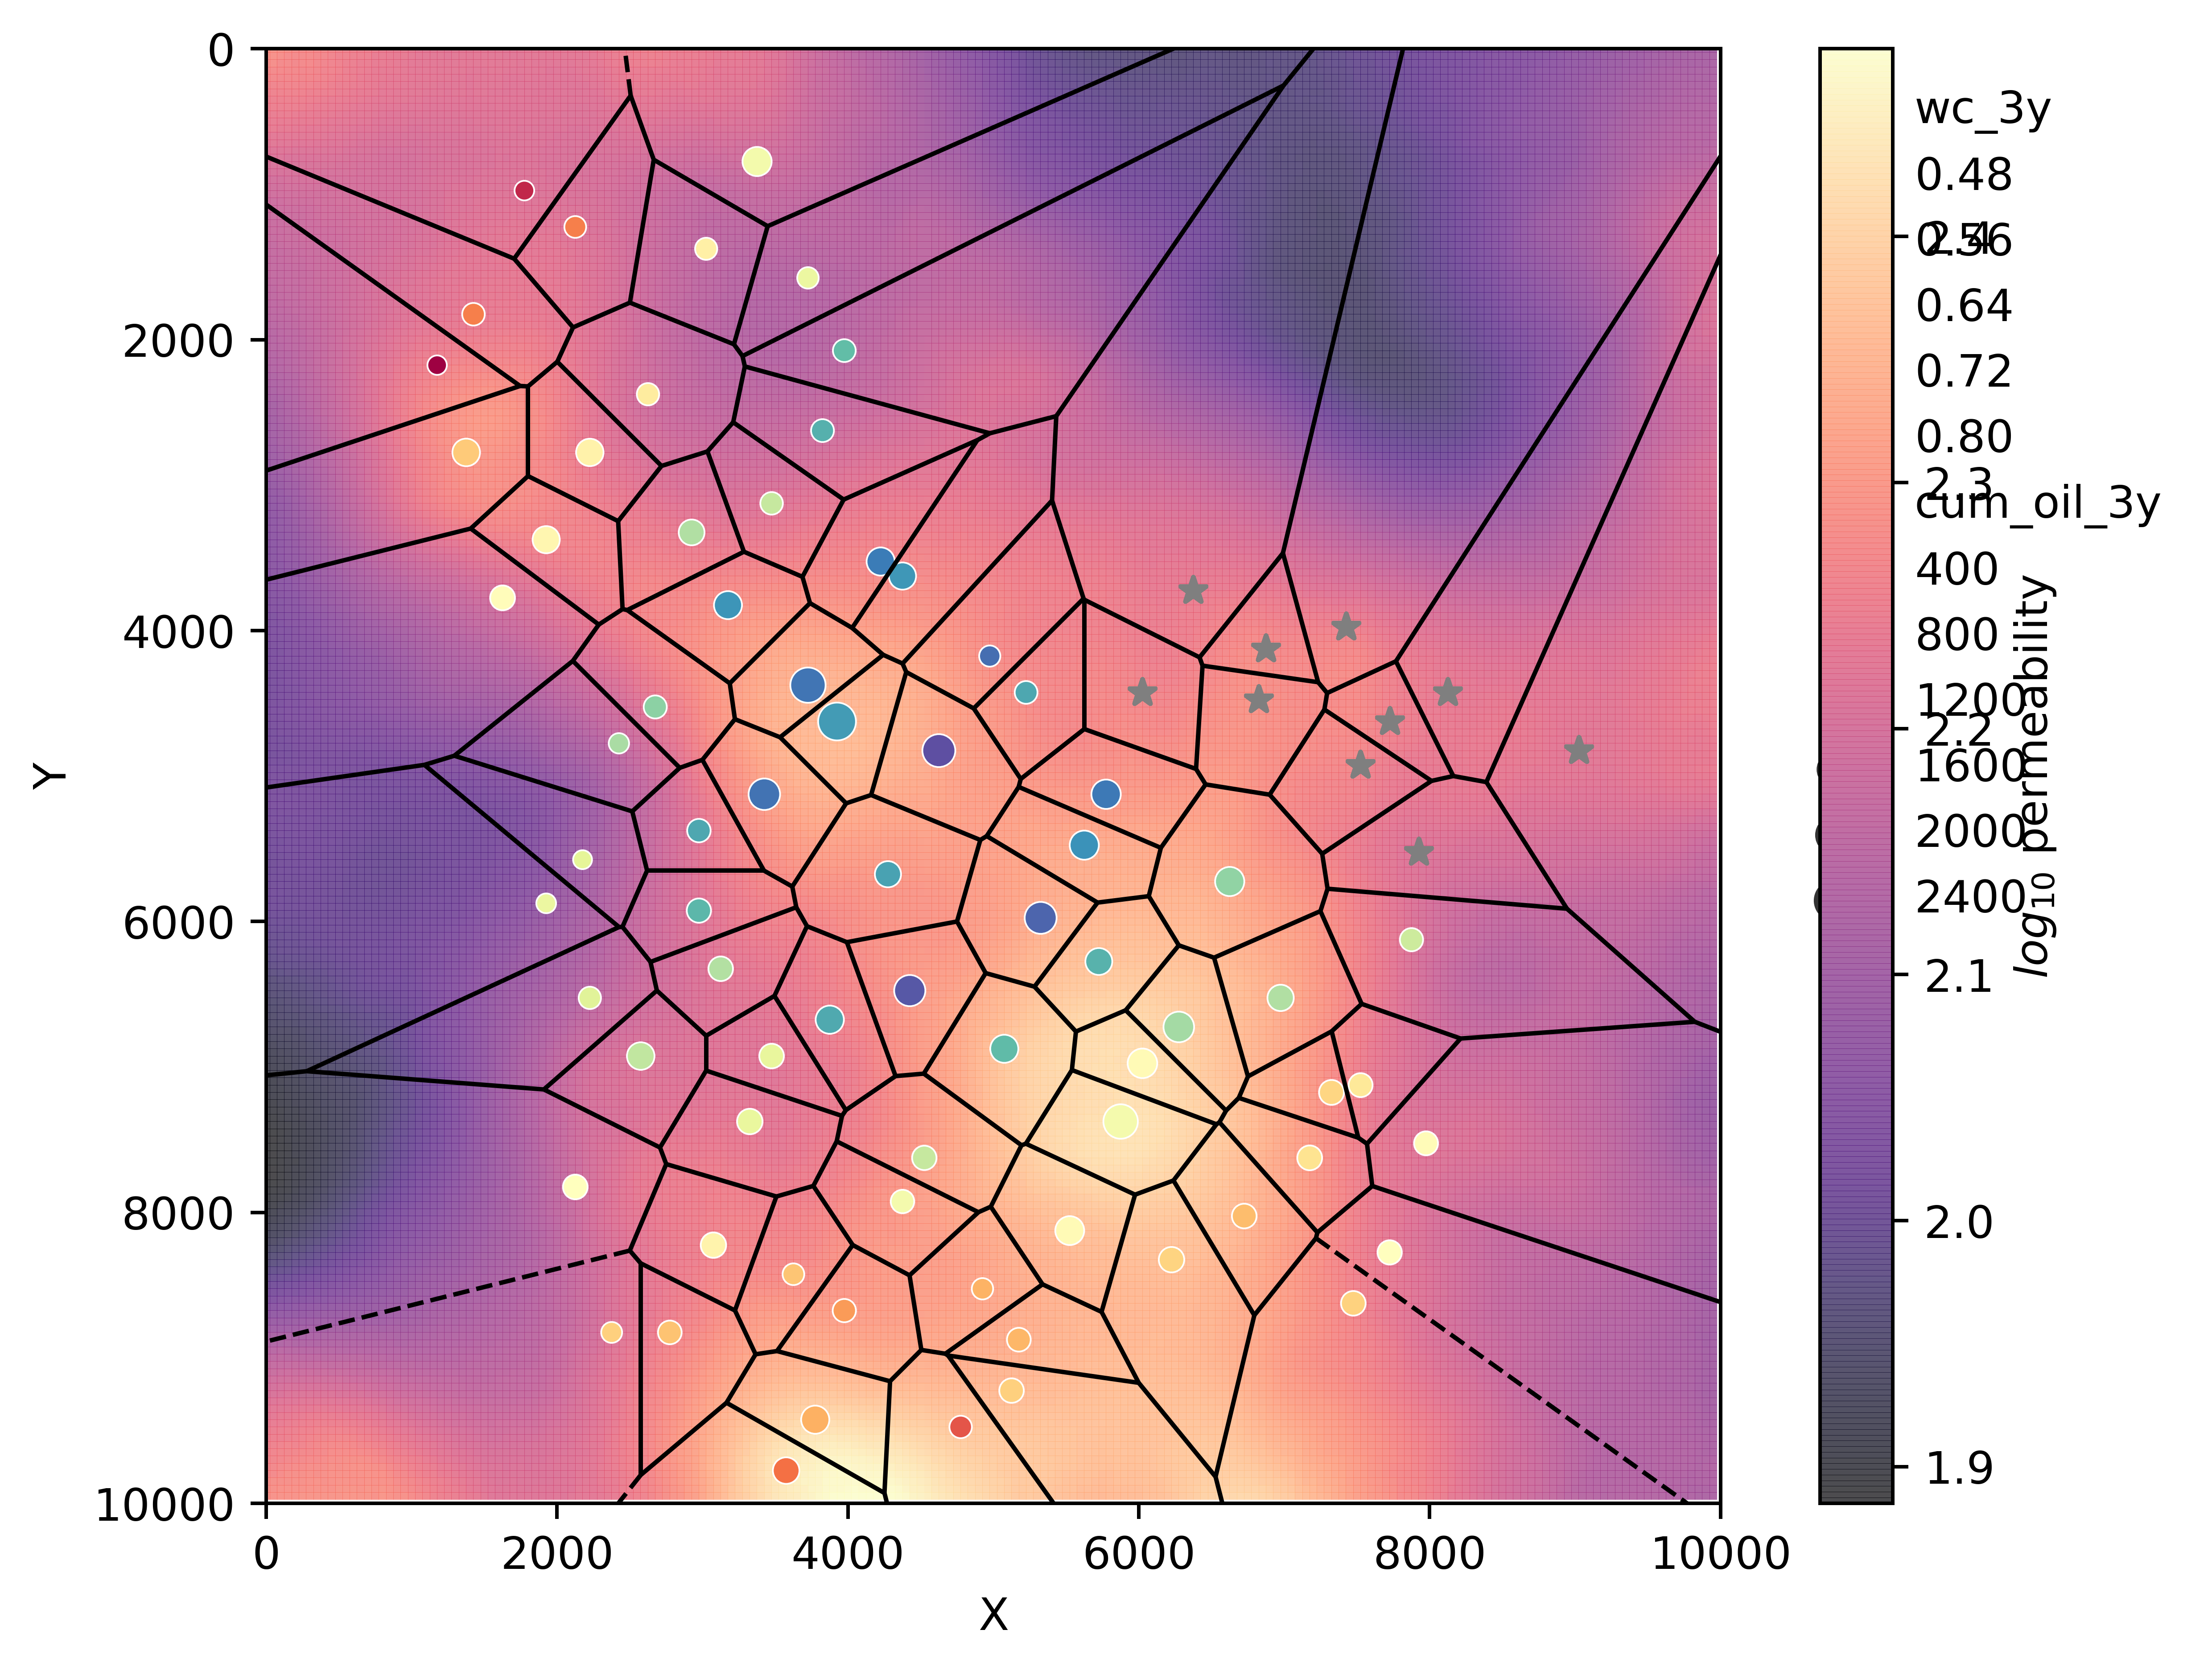

In [30]:
well_points = df_ave.loc[:,['X','Y']].to_numpy()
voronoi_points = Voronoi(well_points)

IDs = df_ave['ID'].to_numpy()
Xs = df_ave['X'].to_numpy()
Ys = df_ave['Y'].to_numpy()

# Plot
cmap = sns.color_palette("Spectral_r", as_cmap=True)

fig, ax = plt.subplots(figsize=(8,6), dpi=720)
im = ax.pcolormesh(X,Y, LOGPERM, shading='auto', alpha=0.7, cmap='magma')
voronoi_plot_2d(voronoi_points, show_vertices=False, ax=ax, show_points=False)
sns.scatterplot(x='X', y='Y', data=df_hist,
                ax=ax, size='cum_oil_3y', hue='wc_3y', palette=cmap)
ax.scatter(df_pre["X"], df_pre["Y"], marker='*', c="tab:gray") 

cbar = fig.colorbar(im, ax=ax,  fraction=0.04)
cbar.set_label('$log_{10}$ permeability')
ax.set_xlim((0,10000)); ax.set_ylim((0,10000))
ax.set_aspect('equal', adjustable='box')
ax.invert_yaxis()
plt.legend(bbox_to_anchor=(1.02, 1), loc=2, frameon=False);

In [31]:
def voronoi_areas(points):
    v = Voronoi(points)
    vol = np.zeros(v.npoints)
    for i, reg_num in enumerate(v.point_region):
        indices = v.regions[reg_num]
        if -1 in indices: # some regions can be opened
            vol[i] = np.inf
        else:
            vol[i] = ConvexHull(v.vertices[indices]).volume
    return vol

Calculate Voronoi area for each well

In [32]:
area = voronoi_areas(well_points)
max = area[51]
area = np.where(area > max, max, area).tolist()

# Append to dataframe
df_ave["area"] = area

---
## 3 - Regression <a class="anchor" id="regression"></a>

**Training data:**

In [33]:
data = pd.concat([df_ave.iloc[:73,:], df_hist.drop(['ID', 'X', 'Y'], axis=1)], axis=1)
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,73.0,3.700000e+01,21.217131,1.000000e+00,1.900000e+01,3.700000e+01,5.500000e+01,7.300000e+01
index,73.0,7.295000e+02,424.342629,9.500000e+00,3.695000e+02,7.295000e+02,1.089500e+03,1.449500e+03
X,73.0,4.188699e+03,1783.143687,1.175000e+03,2.925000e+03,3.875000e+03,5.325000e+03,7.975000e+03
Y,73.0,5.770890e+03,2405.487844,7.750000e+02,3.825000e+03,6.125000e+03,7.625000e+03,9.775000e+03
depth,73.0,3.055811e+03,3.282321,3.050370e+03,3.052790e+03,3.055810e+03,3.058310e+03,3.061550e+03
por,73.0,1.280356e-01,0.010936,1.040741e-01,1.203099e-01,1.278622e-01,1.347575e-01,1.577506e-01
perm,73.0,3.263048e+02,108.607766,1.382684e+02,2.503758e+02,3.165095e+02,3.945114e+02,6.812787e+02
ai,73.0,7.326029e+06,97057.323348,7.041786e+06,7.287669e+06,7.334721e+06,7.379185e+06,7.498752e+06
rho,73.0,2.047421e+00,0.141070,1.781072e+00,1.924253e+00,2.008027e+00,2.168241e+00,2.311729e+00
Vc,73.0,3.692465e+03,275.928692,3.226717e+03,3.444442e+03,3.688454e+03,3.906540e+03,4.355739e+03


### 3.1 Feature Selection using Random Forest Feature Importances

In [34]:
data =data.drop(columns = ['depth','ID', 'index', 'X', 'Y', 'ai', 'rho', 'Vc', 'E',
       'Vs', 'G', 'log_perm','perm_w_ave', 'perm_h_ave','cum_oil_1y', 'cum_oil_2y','cum_water_1y',
       'cum_water_2y', 'cum_water_3y', 'wc_1y', 'wc_2y', 'wc_3y'])

data.columns

Index(['por', 'perm', 'SS_perm', 'SS_por', 'SS_fraction', 'SS-Sh_perm',
       'SS-Sh_por', 'SS-Sh_fraction', 'Sh-SS_perm', 'Sh-SS_por',
       'Sh-SS_fraction', 'Sh_perm', 'Sh_por', 'Sh_fraction', 'dist_woc',
       'SS+Sh-SS_fraction', 'dist_frac', 'area', 'cum_oil_3y'],
      dtype='object')

In [35]:
n = len(data.columns)
X = data.iloc[:,0:n-1].to_numpy()
y = data.iloc[:,n-1].to_numpy()

Text(0.5, 0, 'Relative Importance')

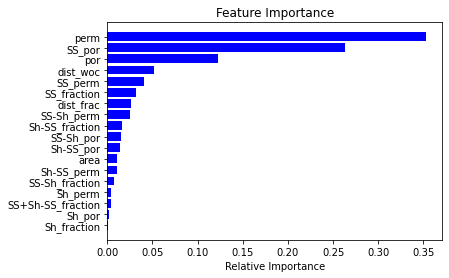

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)
randreg = RandomForestRegressor()
randreg.fit(X_train,y_train)
#Principal Component Analysis
features = data.columns[:-1]
importances = randreg.feature_importances_
indices = np.argsort(importances)
plt.figure(3) #the axis number
plt.title('Feature Importance')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')

### 3.2 Regressions with selected important features

In [37]:
#Final dataset with important features
data =data.drop(columns = ['SS_perm', 'por','SS_fraction', 'SS-Sh_perm',
       'SS-Sh_por', 'SS-Sh_fraction', 'Sh-SS_perm', 'Sh-SS_por',
       'Sh-SS_fraction', 'Sh_perm', 'Sh_por', 'Sh_fraction','SS+Sh-SS_fraction', 'dist_frac','area'])
n = len(data.columns)
X = data.iloc[:,0:n-1].to_numpy()
y = data.iloc[:,n-1].to_numpy()
data.columns

Index(['perm', 'SS_por', 'dist_woc', 'cum_oil_3y'], dtype='object')

In [38]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
scores = cross_val_score(lm, X, y, scoring='neg_mean_squared_error', cv=10)
print(-scores)
print("Av MSE")
print(-scores.mean())

[46459.99395135  5195.27317615 38283.59606268 43447.45980976
 58332.75911912 30506.09462542  9356.11015227 63849.79566377
 48428.11974636 64406.76226009]
Av MSE
40826.59645669728


In [39]:
from sklearn.linear_model import Ridge
lm = Ridge(alpha=0.01, normalize=True)
scores = cross_val_score(lm, X, y, scoring='neg_mean_squared_error', cv=10)
print(-scores)
print("Av MSE")
print(-scores.mean())

[46630.89751692  5261.07587387 38088.06394869 43178.50039779
 57876.03114258 30598.10576808  9404.62171342 63565.57077349
 49595.68844312 63061.12315595]
Av MSE
40725.96787338975


In [40]:
from sklearn.linear_model import Lasso
lm = Lasso(alpha=0.01, normalize=True)
scores = cross_val_score(lm, X, y, scoring='neg_mean_squared_error', cv=10)
print(-scores)
print("Av MSE")
print(-scores.mean())

[46449.52440782  5197.31140253 38262.42843616 43409.61664388
 58354.08357596 30526.83402993  9358.95985478 63843.73604879
 48462.97524376 64400.23995165]
Av MSE
40826.570959526245


In [41]:
lm = RandomForestRegressor()
scores = cross_val_score(lm, X, y, scoring='neg_mean_squared_error', cv=10)
print(-scores)
print("Av MSE")
print(-scores.mean())

[ 47395.59652592  12641.34190306  40459.90738532  27458.79560185
  65420.71306744  41443.48782254  34282.21180804  74791.91512106
 101928.63352613  47906.8249386 ]
Av MSE
49372.94276999506


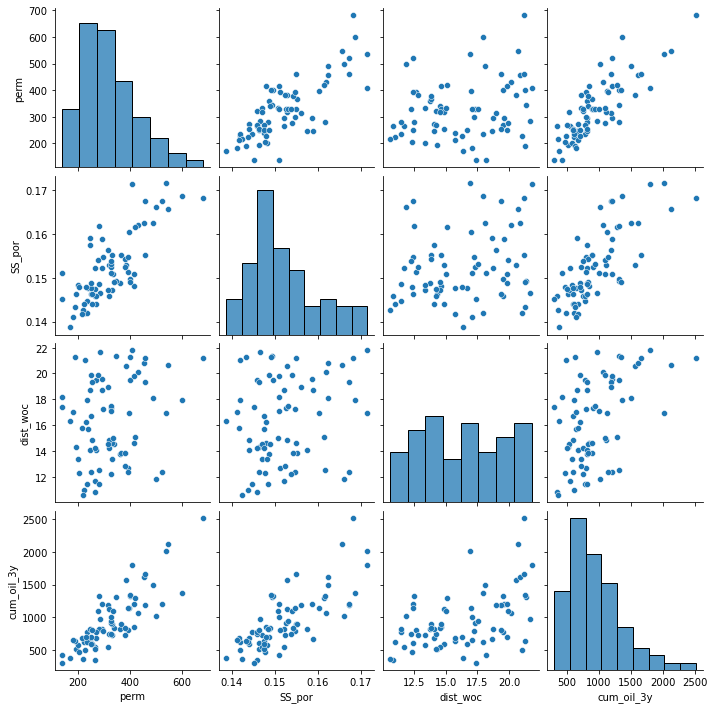

In [42]:
sns.pairplot(data.iloc[:,0:n])

### 3.3 Hyperparameter tuning for Lasso, Ridge regressions

Note: The codes used for hyperparameter tuning of linear approaches is obtained from https://github.com/GeostatsGuy/PythonNumericalDemos

In [43]:
from sklearn.preprocessing import StandardScaler            # standardize the features
scaler = StandardScaler()                                   # instantiate the scaler 
sfeatures = scaler.fit_transform(data.values)              # standardize all the values extracted from the DataFrame 
df_nmv = pd.DataFrame()                                     # instantiate a new DataFrame
df_nmv = pd.DataFrame(sfeatures, index=data.index, columns=data.columns) # copy the standardized values into the new DataFrame
df_nmv.head()                                               # preview the the new DataFrame

,perm,SS_por,dist_woc,cum_oil_3y
0,0.821562,-0.545167,-0.533487,-0.219481
1,-0.296994,0.832819,1.003435,0.609896
2,-0.859463,-0.970532,-1.490612,-0.374004
3,0.529757,0.066874,1.288732,1.481765
4,-0.560365,-0.020265,-1.423123,-0.919438


In [44]:
df_nmv.describe().transpose()                               # summary statistics from the new DataFrame

,count,mean,std,min,25%,50%,75%,max
perm,73.0,-1.772745e-16,1.00692,-1.743317,-0.703950,-0.090814,0.632355,3.291021
SS_por,73.0,-3.304054e-16,1.00692,-1.741600,-0.724843,-0.172700,0.364261,2.468762
dist_woc,73.0,-5.353404e-16,1.00692,-1.760571,-0.766633,0.000294,0.926742,1.669128
cum_oil_3y,73.0,-1.596896e-17,1.00692,-1.485591,-0.698049,-0.284731,0.572865,3.687923


In [45]:
X_train, X_test, y_train, y_test = train_test_split(df_nmv.iloc[:,:3], pd.DataFrame({'cum_oil_3y':df_nmv['cum_oil_3y']}), test_size=0.15, random_state=73073)
print('Number of training data = ' + str(len(X_train)) + ' and number of testing data = ' + str(len(X_test)))

Number of training data = 62 and number of testing data = 11


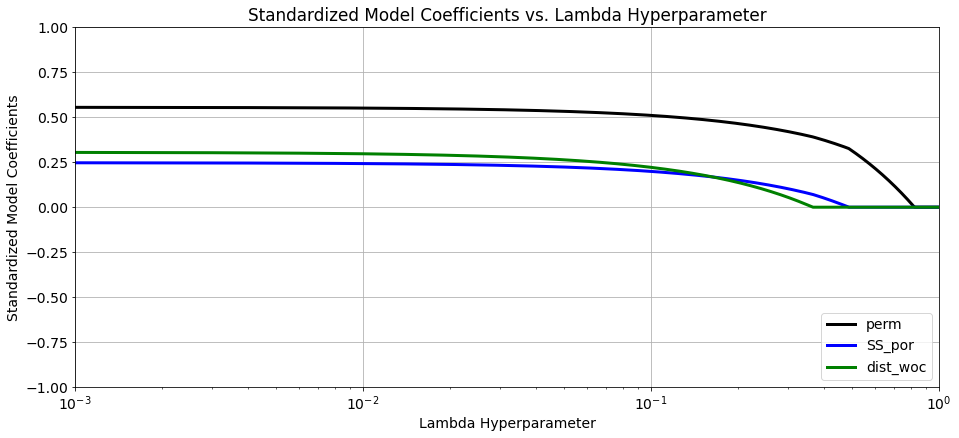

In [46]:
font = {'size'   : 14}
plt.rc('font', **font)
plt.rcParams["figure.figsize"] = (8,5)

nbins = 1000                                                # number of bins to explore the hyperparameter 
df_nmv.describe().transpose()                               # summary statistics from the new DataFrame
lams = np.linspace(0.001,1.0,nbins)                         # make a list of lambda values
coefs = np.ndarray((nbins,3))

index = 0
for lam in lams:
    lasso_reg = Lasso(alpha=lam)                            # instantiate the model
    lasso_reg.fit(X_train, y_train)                         # fit model
    coefs[index,:] = lasso_reg.coef_                        # retreive the coefficients
    index = index + 1
    
color = ['black','blue','green','red']
plt.subplot(111)                                            # plot the results
for ifeature in range(0,3):
    plt.semilogx(lams,coefs[:,ifeature], label = data.columns[ifeature], c = color[ifeature], linewidth = 3.0)

plt.title('Standardized Model Coefficients vs. Lambda Hyperparameter'); plt.xlabel('Lambda Hyperparameter'); plt.ylabel('Standardized Model Coefficients')
plt.xlim(0.001,1); plt.ylim(-1.0,1.0); plt.grid(); plt.legend(loc = 'lower right')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1., wspace=0.2, hspace=0.2)
plt.show()

What do we see?

1. for a very low lambda value, all features are included

2. as we increase the lambda hyperparameter, area is the first predictor feature to be removed

3. then SS_por, dist_woc and finally perm

4. at $\lambda \ge 0.9$ all features are removed.

Let's repeat this workflow with ridge regression for contrast.

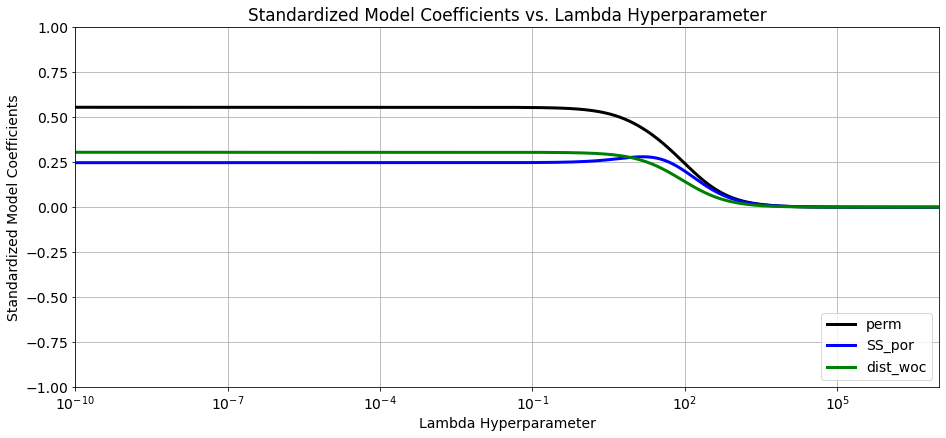

In [47]:
nbins = 5000                                                # number of bins to explore the hyperparameter 
lams = np.logspace(-10,7,nbins)       
ridge_coefs = np.ndarray((nbins,3))

index = 0
for lam in lams:
    ridge_reg = Ridge(alpha=lam)
    ridge_reg.fit(X_train, y_train) # fit model
    ridge_coefs[index,:] = ridge_reg.coef_
    index = index + 1
    
color = ['black','blue','green','red']
plt.subplot(111)
for ifeature in range(0,3):
    plt.semilogx(lams,ridge_coefs[:,ifeature], label = data.columns[ifeature], c = color[ifeature], linewidth = 3.0)

plt.title('Standardized Model Coefficients vs. Lambda Hyperparameter'); plt.xlabel('Lambda Hyperparameter'); plt.ylabel('Standardized Model Coefficients')
plt.xlim(1.0e-10,1.0e7); plt.ylim(-1.0,1.0); plt.grid(); plt.legend(loc = 'lower right')

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=1., wspace=0.2, hspace=0.2)
plt.show()

Ridge regression is quite different in the response of predictor feature to change in the lambda hyperparameter.

1. there is no selective removal of predictor features as the lambda hyperparameter increases

2. a major component is uniform shrinkage of all coefficients towards zero for $\lambda \in [10^1, 10^5]$

Let's check the model performance for all three models over the hyperparameters. We check the mean squared error and the variance explained for:

1. linear regression

2. ridge regression

3. lasso regression

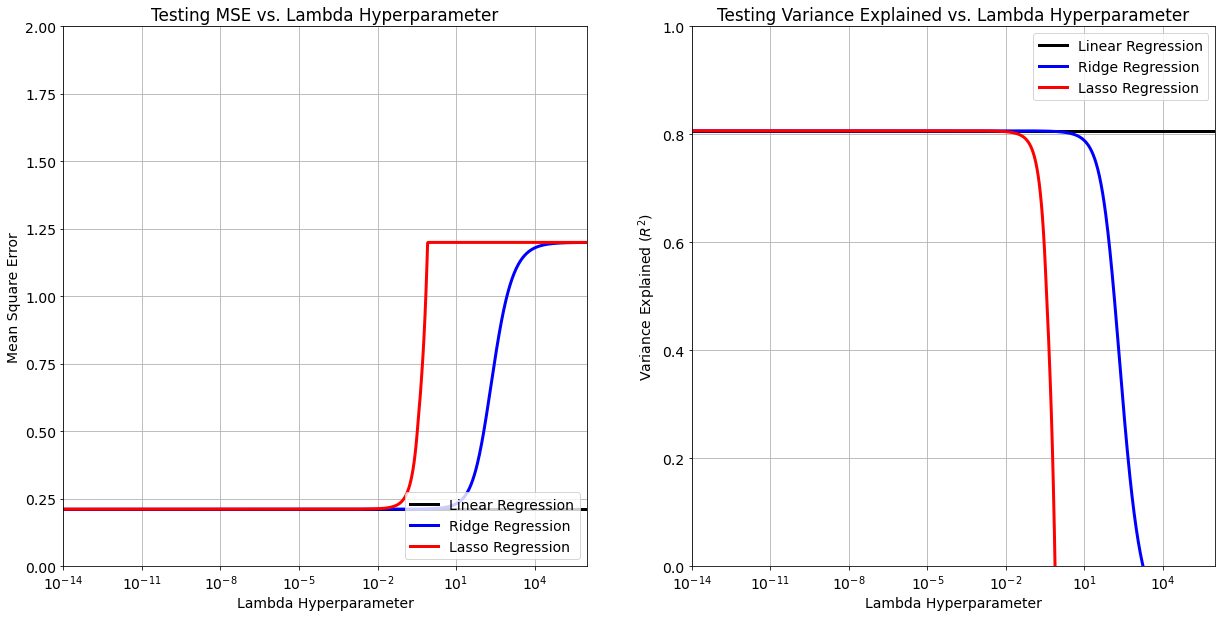

In [48]:
from sklearn import metrics 
nbins = 1000                                               # number of bins
lams = np.logspace(-14,6,nbins)                           # assign equal bins in log space
ridge_error = []; lasso_error = []; linear_error = []
ridge_r2 = []; lasso_r2 = []; linear_r2 = []

linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train) # fit model
linear_predict = linear_reg.predict(X_test)
linear_err = metrics.mean_squared_error(y_test["cum_oil_3y"],linear_predict)
linear_r = metrics.r2_score(y_test["cum_oil_3y"],linear_predict)

index = 0
for lam in lams:
    ridge_reg = Ridge(alpha=lam)
    ridge_reg.fit(X_train, y_train) # fit model
    ridge_predict = ridge_reg.predict(X_test)
    ridge_error.append(metrics.mean_squared_error(y_test["cum_oil_3y"],ridge_predict))
    ridge_r2.append(metrics.r2_score(y_test["cum_oil_3y"],ridge_predict))
    lasso_reg = Lasso(alpha=lam)
    lasso_reg.fit(X_train, y_train) # fit model
    lasso_predict = lasso_reg.predict(X_test)
    lasso_error.append(metrics.mean_squared_error(y_test["cum_oil_3y"],lasso_predict))
    lasso_r2.append(metrics.r2_score(y_test["cum_oil_3y"],lasso_predict))
    linear_error.append(linear_err)
    linear_r2.append(linear_r)
    index = index + 1
    
color = ['black','blue','green','red']

plt.subplot(121)
plt.semilogx(lams,linear_error, label = 'Linear Regression', c = 'black', linewidth = 3.0)
plt.semilogx(lams,ridge_error, label = 'Ridge Regression', c = 'blue', linewidth = 3.0)
plt.semilogx(lams,lasso_error, label = 'Lasso Regression', c = 'red', linewidth = 3.0)
plt.title('Testing MSE vs. Lambda Hyperparameter'); plt.xlabel('Lambda Hyperparameter'); plt.ylabel('Mean Square Error')
plt.xlim(1.0e-14,1.0e6); plt.ylim(0.0,2.0); plt.grid(); plt.legend(loc = 'lower right')

plt.subplot(122)
plt.semilogx(lams,linear_r2, label = 'Linear Regression', c = 'black', linewidth = 3.0)
plt.semilogx(lams,ridge_r2, label = 'Ridge Regression', c = 'blue', linewidth = 3.0)
plt.semilogx(lams,lasso_r2, label = 'Lasso Regression', c = 'red', linewidth = 3.0)
plt.title('Testing Variance Explained vs. Lambda Hyperparameter'); plt.xlabel('Lambda Hyperparameter'); plt.ylabel('Variance Explained ($R^2$)')
plt.xlim(1.0e-14,1.0e6); plt.ylim(0.0,1.0); plt.grid(); plt.legend(loc = 'upper right')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.5, wspace=0.2, hspace=0.2)
plt.show()

Since the performances of Lasso, Ridge and Linear regression are similar for Lambda Hyperparameter less than 0.01, we decided to use linear regression for the predictions.

### 3.4 Creating the final linear regression model

In [49]:
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.8079575704799041

In [50]:
reg.coef_[0],reg.coef_[1],reg.coef_[2]

(2.254608834816921, 13416.193300298684, 39.8875647753813)

In [51]:
reg.intercept_

-2489.2188999688765

In [52]:
data["predicted"] = reg.intercept_ + (data["perm"] * reg.coef_[0]) + (data["SS_por"] * reg.coef_[1]) + (data["dist_woc"] * reg.coef_[2])

---
## 4- Uncertainty Analysis <a class="anchor" id="uncertainty_analysis"></a>

### 4.1 Creating required features for prediction wells

In [53]:
df_pre2 = df_all2[df_all2.ID>73].reset_index(drop=True)

IDs = np.arange(74,84,1)

perm_ave = np.zeros(len(IDs))
perm_std = np.zeros(len(IDs))
SS_por_ave = np.zeros(len(IDs))
SS_por_std = np.zeros(len(IDs))

In [54]:
for i, ID in enumerate(IDs):
    perm_ave[i] = df_pre2[df_pre2.ID==ID]['perm'].mean()
    perm_std[i] = df_pre2[df_pre2.ID==ID]['perm'].std()
    SS_por_ave[i] = df_pre2.loc[df_pre2.facies=='SS' ][df_pre2.ID==ID]['por'].mean()
    SS_por_std[i] = df_pre2.loc[df_pre2.facies=='SS' ][df_pre2.ID==ID]['por'].std()
    
    
dist_woc = df_ave[df_ave.ID>73]['dist_woc']
    
data_pre = pd.DataFrame({'ID':IDs,
                         'perm_ave':perm_ave,
                        'perm_std':perm_std,
                        'SS_por_ave':SS_por_ave,
                         'SS_por_std':SS_por_std,
                        'dist_woc': dist_woc}
                       )

In [55]:
data_pre =data_pre.reset_index(drop=True) 
data_pre

,ID,perm_ave,perm_std,SS_por_ave,SS_por_std,dist_woc
0,74,238.301830,185.814126,0.147915,0.009400,16.89
1,75,250.501987,232.791884,0.148115,0.012667,17.56
2,76,331.495344,284.676402,0.160804,0.015322,18.14
3,77,469.394732,361.166575,0.164280,0.010554,19.64
4,78,355.002763,290.127056,0.157412,0.011941,18.39
5,79,500.609357,333.193058,0.160165,0.011088,19.27
6,80,385.385965,351.901634,0.154846,0.016536,18.41
7,81,252.975910,221.345365,0.149604,0.009076,15.73
8,82,302.569012,266.308387,0.151994,0.012160,20.66
9,83,240.014674,181.022229,0.148590,0.010699,19.30


In [56]:
data_pre["predicted"] = reg.intercept_ + (data_pre["perm_ave"] * reg.coef_[0]) + (data_pre["SS_por_ave"] * reg.coef_[1]) + (data_pre["dist_woc"] * reg.coef_[2])

### 4.1 Creating set of realizations

In [57]:
woc = np.zeros(len(IDs))
realizations = []
for i, ID in enumerate(IDs):
    perm_ave[i] = data_pre[data_pre.ID==ID]['perm_ave'].values
    perm_std[i] = data_pre[data_pre.ID==ID]['perm_std'].values
    SS_por_ave[i] = data_pre[data_pre.ID==ID]['SS_por_ave'].values
    SS_por_std[i] = data_pre[data_pre.ID==ID]['SS_por_std'].values    
    woc[i] = data_pre[data_pre.ID==ID]['dist_woc'].values   
    
    perm = np.random.normal(perm_ave[i],perm_std[i],size=100)
    sspor = np.random.normal(SS_por_ave[i],SS_por_std[i],size=100)
    predictions = np.abs(reg.intercept_ + (perm * reg.coef_[0]) + (sspor * reg.coef_[1]) + (woc[i] * reg.coef_[2]))
    realizations.append(predictions)

In [58]:
columns = []
wellids = []
for i in range(1,101):
    columns.append("R" + str(i)+ ", MSTB")
    
for i in range(74,84):
    wellids.append("Well_no_" + str(i))

df_final = pd.DataFrame(data=realizations,columns = columns)

df_final["Well_ID"] = wellids
df_final["Prediction, MSTB"] = data_pre["predicted"]

cols = list(df_final.columns)
cols = [cols[-1]] + cols[:-1]
df_final = df_final[cols]

cols = list(df_final.columns)
cols = [cols[-1]] + cols[:-1]
df_final = df_final[cols]

In [59]:
df_final

,Well_ID,"Prediction, MSTB","R1, MSTB","R2, MSTB","R3, MSTB","R4, MSTB","R5, MSTB","R6, MSTB","R7, MSTB","R8, MSTB",...,"R91, MSTB","R92, MSTB","R93, MSTB","R94, MSTB","R95, MSTB","R96, MSTB","R97, MSTB","R98, MSTB","R99, MSTB","R100, MSTB"
0,Well_no_74,706.215713,982.415747,1100.255395,1008.132885,1440.593901,566.294678,1239.673641,161.955772,676.841002,...,513.250696,715.085042,224.700138,197.123282,495.930989,990.233477,365.754404,55.735851,768.024729,1451.191721
1,Well_no_75,763.126559,1083.622076,1452.965132,1082.689173,975.044097,717.781366,1559.235001,1130.398727,269.376520,...,969.091081,1037.206213,1284.642911,473.087884,685.023211,904.713793,724.195795,1083.678545,948.548759,780.262448
2,Well_no_76,1139.110793,652.296900,1162.825723,993.348675,1799.762047,850.507938,514.126500,2282.419743,2576.297349,...,2104.651986,1209.590151,2335.210700,2182.158056,804.796300,1142.862151,326.776532,2157.172913,1625.062845,1095.965894
3,Well_no_77,1556.488228,1870.232161,1882.659331,174.654038,1914.767656,899.235515,2073.384026,2865.164620,2499.788939,...,946.882389,2124.204561,176.795993,1539.019024,1703.237460,1151.569004,2332.416436,717.353439,423.191317,1997.394462
4,Well_no_78,1156.572583,1643.680278,821.013411,1207.455239,1690.440840,994.792834,433.896583,1218.630633,2509.062267,...,813.778049,841.510963,1591.618790,777.819027,1702.054370,32.958985,1412.734118,663.724005,1588.225023,697.126009
5,Well_no_79,1556.902910,1962.347643,1089.112073,1732.872034,1771.124187,2333.259089,1142.622643,3141.633712,541.141862,...,932.354269,1581.706368,2338.066533,1248.894637,1300.438825,1685.316775,149.540844,1055.623260,1054.152534,196.870072
6,Well_no_80,1191.445978,1074.222886,384.800767,580.552066,1032.384636,1965.465308,2280.184598,1295.388439,809.034231,...,1856.404748,1299.863837,2402.433032,2347.484194,1240.274660,1520.204635,2119.349660,269.125066,639.316930,1621.383792
7,Well_no_81,715.696361,631.111602,391.232279,1063.695036,788.510334,901.698578,566.518265,794.842795,548.816800,...,1811.240073,850.204907,307.734199,459.161350,436.100050,358.436507,460.960639,927.235465,267.780507,988.613734
8,Well_no_82,1056.209591,711.050252,16.225284,2171.900309,712.166353,1631.101501,1197.127632,871.852291,219.571440,...,1996.968581,939.529920,1436.479340,638.935434,1544.505497,1412.646755,394.807155,1129.526674,1089.219336,1147.859792
9,Well_no_83,815.267451,463.802380,965.246550,1215.769615,645.554818,357.557674,921.852763,799.269636,741.982887,...,61.937986,760.797745,1269.844852,541.091307,1350.442878,1365.855593,1304.962650,585.563379,773.153080,988.148970


In [60]:
df_final.to_csv("solution.csv")